# Statistical Evaluation and Plot Creation of the `libmoeprlnc` Validation Tool

```
Copyright 2021,2022		Tobias Juelg <tobias.juelg@tum.de>
			            Ben Riegel <ben.riegel@tum.de>

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License version 2 as
published by the Free Software Foundation.

See COPYING for more details.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mass_validation import validate_parallel, validate
import math

In [2]:
# theory vales
def theory(gen_size, gf):
    return np.prod([(1 - math.pow(gf, i - 1-gen_size)) for i in range(1, gen_size+1)])

lower_bounds = {256: 0.9960784912118471, 2: 0.288788095086602, 4: 0.68853753712033971, 16: 0.933594707399603}

## Plots for data where libmoeprlnc seed was not touched
Not setting the seed correctly in libmoeprlnc leads to very extreme results even though there have been many iterations performed. This is because every iteration will lead
to the same result (as it is using the same seed over and over again for linear coding) which leads to an average calculated by only one value.

In [4]:

folder_no_seed = "csv_stat_data_no_seed"
# create statistical data
validate_parallel(
    folder=folder_no_seed,
    file_name = "valdation_stats_{gf}_{gs}_{ps}_{loss_rate}_{prefill}.csv",
    gf = [2], #, 4, 16, 256],
    gs = range(1, 101),
    ps = [50],
    prefill = True,
    iterations = 5000,
    loss_rate=[0.0]
)

Starting to validate with 24 processes


In [5]:

files = os.listdir(folder_no_seed)
dfs = {2: [None for _ in range(100)], 4: [None for _ in range(100)], 16: [None for _ in range(100)], 256: [None for _ in range(100)]}
for file in files:
    confs = file.split("_")
    dfs[int(confs[2])][int(confs[3])-1] = pd.read_csv(os.path.join(folder_no_seed, file))

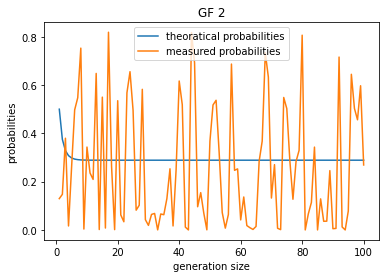

mean, std:
0.24603703703703703 0.24686907833532823
theoratical lower bound:
0.288788095086602
derivation:
0.042751058049565


In [6]:

def plot_for_q(field):
    # calculate averages over all iterations
    gen_sizes = dfs[field]
    x = []
    y = []
    y_t = []
    for gen_size in gen_sizes:
        # iterations
        x.append(gen_size["gen_size"][0])
        y.append(sum(gen_size["linear_dependent"]==0)/len(gen_size["linear_dependent"]))
        #print(sum(gen_size["linear_dependent"]==0))
        y_t.append(theory(gen_size["gen_size"][0], field))
        

    # for each gf, plot x=generation size, y=percentage linear dependent

    #plt.plot((x[0], x[-1]), (lower_bounds[field], lower_bounds[field]), label="theoratical lower bound")
    plt.plot(x, y_t, label="theoratical probabilities")
    plt.plot(x, y, label="measured probabilities")

    plt.legend()
    plt.ylabel('probabilities')
    plt.xlabel('generation size')
    plt.title(f"GF {field}")
    plt.savefig(f"gf{field}_noseed.png", dpi=200)#, bbox_inches='tight')
    plt.show()

    # print stds and mean for larger than 20
    x = np.array(x)
    y = np.array(y)
    print("mean, std:")
    print(np.mean(y[x>=20]), np.std(y[x>=20]))
    print("theoratical lower bound:")
    print(lower_bounds[field])
    print("derivation:")
    print(abs(lower_bounds[field]-np.mean(y[x>=20])))
for q in [2]:
    plot_for_q(q)

## Plots where libmoeprlnc is set correctly

Please perform the steps below in order for the following analysis to work. 

Uncomment setting of seed in lines 479 and 480 in `validator.c`. Furthermore, add
```C
void
rlnc_block_set_seed(rlnc_block_t b, unsigned seed)
{
	b->r_seed = seed;
	return;
}
```

to `rlnc.c` and

```C
void rlnc_block_set_seed(rlnc_block_t b, unsigned seed);
```
to rlnc.h in `libmoeprlnc`. Then recompile libmoeprlnc and the validation tool.

In [7]:

folder = "csv_stat_data"
# create statistical data
validate_parallel(
    folder=folder,
    file_name = "valdation_stats_{gf}_{gs}_{ps}_{loss_rate}_{prefill}.csv",
    gf = [2, 4, 16, 256],
    gs = range(1, 101),
    ps = [50],
    prefill = True,
    iterations = 5000,
    loss_rate=[0.0]
)

Starting to validate with 24 processes


In [8]:
files = os.listdir(folder)
dfs = {2: [None for _ in range(100)], 4: [None for _ in range(100)], 16: [None for _ in range(100)], 256: [None for _ in range(100)]}
for file in files:
    confs = file.split("_")
    # print(int(confs[3]))
    dfs[int(confs[2])][int(confs[3])-1] = pd.read_csv(os.path.join(folder, file))

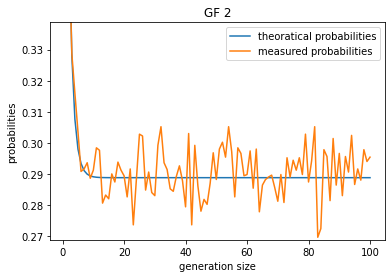

mean, std:
0.29046172839506174 0.00802727707629207
theoratical lower bound:
0.288788095086602
derivation:
0.00167363330845971


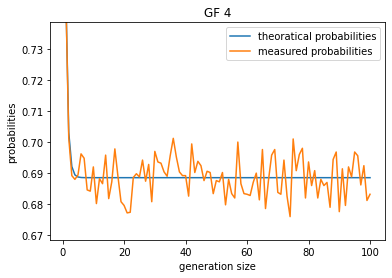

mean, std:
0.688604938271605 0.006238468893245521
theoratical lower bound:
0.6885375371203397
derivation:
6.740115126524504e-05


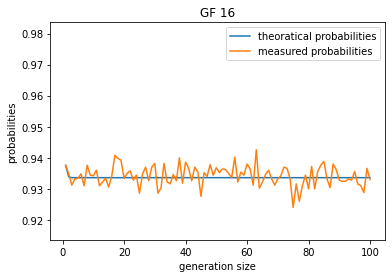

mean, std:
0.9340493827160495 0.0032499999413785376
theoratical lower bound:
0.933594707399603
derivation:
0.0004546753164464956


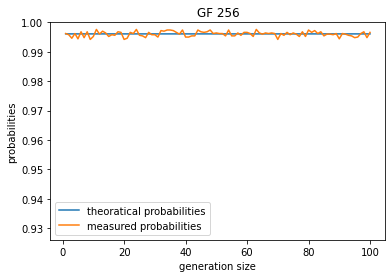

mean, std:
0.9960987654320987 0.0008327396147449428
theoratical lower bound:
0.9960784912118471
derivation:
2.0274220251637054e-05


In [9]:


def plot_for_q(field):
    # calculate averages over all iterations
    gen_sizes = dfs[field]
    x = []
    y = []
    y_t = []
    for gen_size in gen_sizes:
        # iterations
        x.append(gen_size["gen_size"][0])
        y.append(sum(gen_size["linear_dependent"]==0)/len(gen_size["linear_dependent"]))
        y_t.append(theory(gen_size["gen_size"][0], field))

    plt.plot(x, y_t, label="theoratical probabilities")
    plt.plot(x, y, label="measured probabilities")

    plt.legend()
    plt.ylabel('probabilities')
    plt.xlabel('generation size')
    plt.title(f"GF {field}")
    if field != 256:
        plt.ylim(lower_bounds[field]-0.02, lower_bounds[field]+0.05)
    else:
        plt.ylim(lower_bounds[field]-0.07, 1)
    #plt.yscale("log")
    plt.show()
    #plt.savefig(f"gf{field}.png", dpi=200)#, bbox_inches='tight')

    # print stds and mean for larger than 20
    x = np.array(x)
    y = np.array(y)
    print("mean, std:")
    print(np.mean(y[x>=20]), np.std(y[x>=20]))
    print("theoratical lower bound:")
    print(lower_bounds[field])
    print("derivation:")
    print(abs(lower_bounds[field]-np.mean(y[x>=20])))
for q in [2, 4, 16, 256]:
    plot_for_q(q)

In [10]:
def hist(d, bins, xlabel, save=None):
    plt.ylabel('density')
    plt.xlabel(xlabel)
    n, bins, patches = plt.hist(d, bins=bins, density=True, edgecolor="k")
    # plt.xticks(bins)
    plt.axvline(d.mean(), color='red', linestyle='dashed', linewidth=1, label=f"mean$\pm$std: {d.mean():.2f}$\pm${d.std():.2f}")
    plt.legend()
    if save:
        plt.savefig(f"{save}_{xlabel.replace(' ', '_')}.png", dpi=200) #, bbox_inches='tight')
    plt.show()

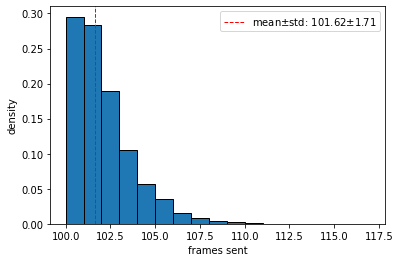

In [11]:
d = dfs[2][99] # gf=2 and gs=100
hist(d["frames_sent"], 17, xlabel="frames sent", save="prefill")

In [12]:
# create non_prefill
validate(gen_size=100, iterations=5000, packet_size=50, galois_field=2, prefill=False, file_name="non_prefill.csv")

src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc.c:207: block empty, unable to retrieve encoded frame
src/rlnc

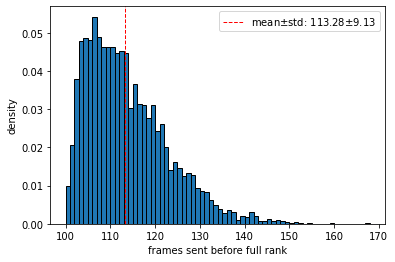

In [13]:

d = pd.read_csv("non_prefill.csv")
# hist(d["linear_dependent"], 68)
hist(d["frames_sent"]-d["frames_delivered_after_full_rank"], 68, "frames sent before full rank", "random_order")

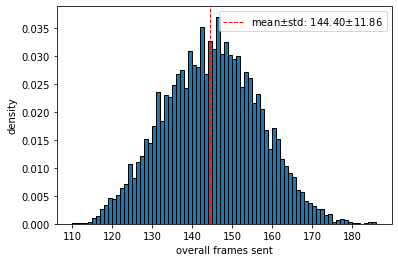

In [14]:

d = pd.read_csv("non_prefill.csv")
hist(d["frames_sent"], 76, "overall frames sent", "random_order")

In [15]:
# create csv with loss
validate(gen_size=100, iterations=5000, packet_size=50, galois_field=2, prefill=True, file_name="with_loss.csv", loss_rate=0.5)

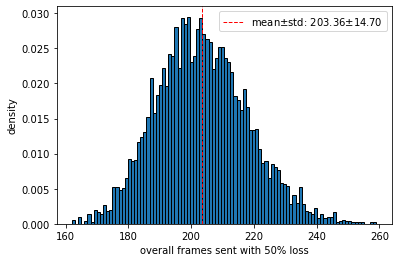

In [16]:
d = pd.read_csv("with_loss.csv")
hist(d["frames_sent"], 98, "overall frames sent with 50% loss", "prefill_with_loss")